## Imports and Dependencies

This section loads all necessary libraries for data handling, visualization, model training, and image augmentation.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from imgaug import augmenters as iaa

## Load and Split MNIST Data

This section splits the loaded MNIST dataset into training, validation, and test sets, and normalizes the pixel values to the range [0, 1]. The splits are performed in two steps to create distinct subsets for training, validation, retraining and testing.

In [3]:
# Load dataset
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.uint8)

# Description
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

Dividing by 255 to scale the data from [0, 255] to [0, 1] The method is effective and fast for normalization image data and preserves the proportional intensity of pixels and ensures consistency across all sets without requiring statistical fitting. 

In [4]:
# Split train_val, test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000, random_state=42)

# Split train, val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

# Normalize all sets
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0
X_train_val = X_train_val / 255.0

print(f"Training data: {X_train.shape}, Validation data: {X_val.shape}, Test data: {X_test.shape}")

Training data: (50000, 784), Validation data: (10000, 784), Test data: (10000, 784)


## Function for Training and Evaluation

This section defines a utility function to train a model, evaluate its performance on a specified dataset (validation or test), and visualize the results using accuracy, classification report, and a confusion matrix. 

In [5]:
# Function - train & evaluate 
def train_and_evaluate(model, X_train, y_train, X_val, y_val, set_name="Validation"):
    """
    Train and validate a model.
    Parameters:
    - model: Sklearn-model
    - X_train, y_train: Training data
    - X_val, y_val: Validation data
    - set_name: Name of validation data
    """
    # Fit model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_val)
    
    # Accuracy
    acc = accuracy_score(y_val, y_pred)
    print(f"Accuracy on {set_name} set: {acc:.4f}")
    
    # Precision, recall, f1-score
    print(f"\nClassification Report ({set_name} set):")
    print(classification_report(y_val, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix ({set_name} set)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    return model, acc

## Exploratory Data Analysis (EDA)

This section explores the MNIST dataset to understand its structure and characteristics by visualizing sample digits, check the distribution of classes, compute mean images per digit, analyze pixel intensity distribution, and examine pixel variance. 

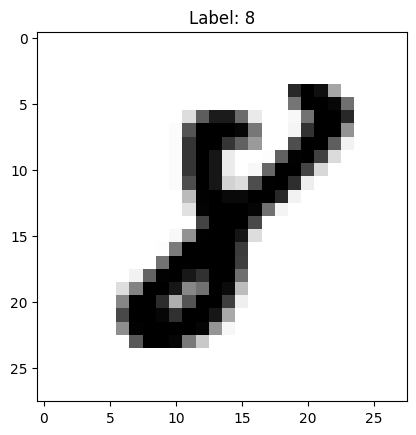

In [6]:
# Check random labels & numbers
plt.imshow(X_train[4].reshape(28, 28), cmap='gray_r')
plt.title(f"Label: {y_train[4]}")
plt.show()

In [7]:
# Distribution of classes
print("Class distribution in training set:", np.bincount(y_train))

Class distribution in training set: [4923 5567 5016 5079 4952 4491 4970 5168 4868 4966]


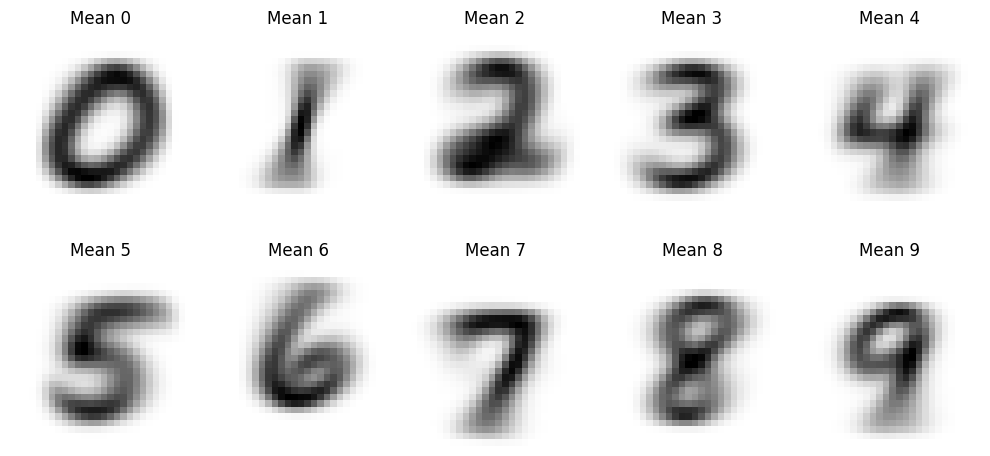

In [8]:
# Mean pixel value per class (0-9)
mean_images = np.zeros((10, 28, 28))
for i in range(10):
    mean_images[i] = np.mean(X_train[y_train == i], axis=0).reshape(28, 28)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(mean_images[i], cmap='gray_r')
    plt.title(f"Mean {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

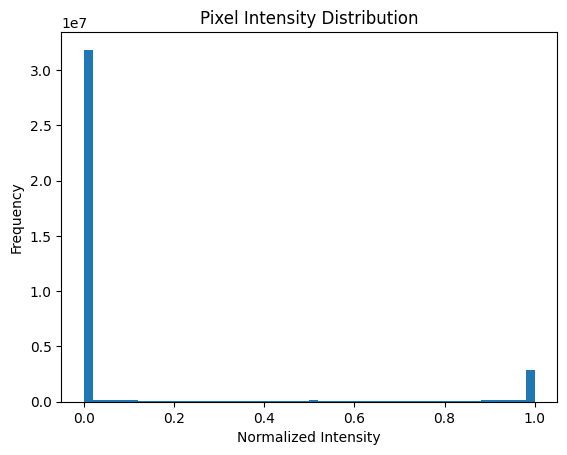

In [9]:
# Histogram of pixel values
plt.hist(X_train.flatten(), bins=50, range=(0, 1))
plt.title("Pixel Intensity Distribution")
plt.xlabel("Normalized Intensity")
plt.ylabel("Frequency")
plt.show()

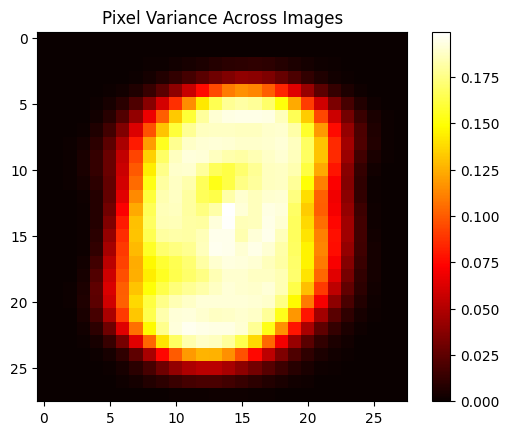

In [10]:
# Pixel variance
pixel_variance = np.var(X_train, axis=0)
plt.imshow(pixel_variance.reshape(28, 28), cmap='hot')
plt.title("Pixel Variance Across Images")
plt.colorbar()
plt.show()

## Logistic Regression - Baseline

This section implements Logistic Regression as a baseline model to establish a performance benchmark for the MNIST classification. Pipeline with GridSearchCV is used to tune the regularization parameter (C), evaluate the best model on the validation set, and save it for future use. 

In [11]:
# Create pipeline for LR
pipeline_lr = Pipeline([
    ("logistic_regression", LogisticRegression(max_iter=1000, random_state=42))
])

In [12]:
# Define parameter grid 
param_grid = {
    "logistic_regression__C": [0.01, 0.05, 0.2, 0.5]
}

In [13]:
# Run GridSearchCV
grid_search = GridSearchCV(pipeline_lr, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Best parameters: {'logistic_regression__C': 0.2}
Best accuracy: 0.9201800531372069


Accuracy on Validation set: 0.9233

Classification Report (Validation set):
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       997
           1       0.96      0.97      0.97      1158
           2       0.92      0.91      0.91      1007
           3       0.91      0.88      0.90      1028
           4       0.93      0.94      0.94       966
           5       0.87      0.87      0.87       885
           6       0.93      0.96      0.95       945
           7       0.95      0.93      0.94      1070
           8       0.89      0.87      0.88       988
           9       0.90      0.92      0.91       956

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



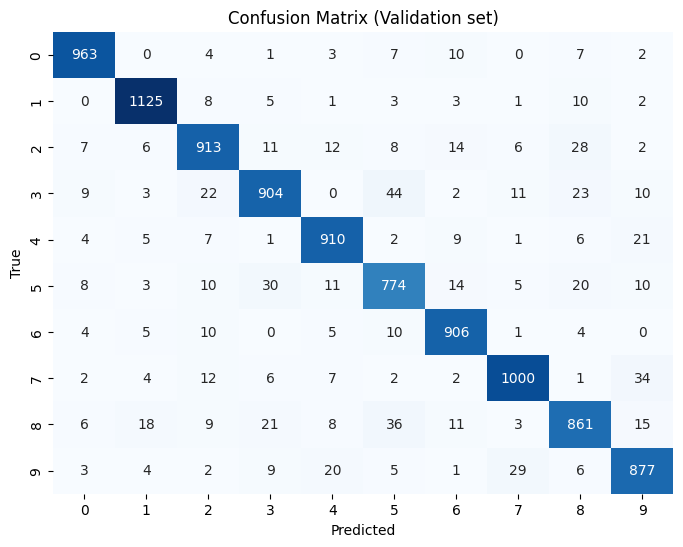

In [14]:
# Evaluate the best model
best_lr_model = grid_search.best_estimator_
lr_model, lr_acc = train_and_evaluate(best_lr_model, X_train, y_train, X_val, y_val, set_name="Validation")

In [15]:
# Save trained model
joblib.dump(lr_model, "logistic_regression_model.pkl")

['logistic_regression_model.pkl']

## Support Vector Machine

This section implements a Support Vector Machine (SVM) with an RBF kernel as a more advanced model. Pipeline with GridSearchCV is used to tune the hyperparameters C (regularization) and gamma (kernel coefficient), evaluate the best model on the validation set, and save it. SVM was chosen due to its strong performance on image data.

In [16]:
# Create pipeline for SVM
pipeline_svm = Pipeline([
    ("svm", SVC(kernel="rbf", random_state=42))
])

In [17]:
# Define parameter grid 
param_grid_svm = {
    "svm__C": [1.0, 5.0, 10.0],
    "svm__gamma": ["scale", 0.01, 0.1]
} 

In [18]:
# Run GridSearchCV
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search_svm.fit(X_train, y_train)

# Print results
print("Best parameters for SVM:", grid_search_svm.best_params_)
print("Best accuracy for SVM:", grid_search_svm.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters for SVM: {'svm__C': 10.0, 'svm__gamma': 'scale'}
Best accuracy for SVM: 0.9806000075846316


Accuracy on Validation set: 0.9852

Classification Report (Validation set):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       997
           1       0.99      0.99      0.99      1158
           2       0.98      0.99      0.98      1007
           3       0.99      0.98      0.98      1028
           4       0.99      0.99      0.99       966
           5       0.98      0.98      0.98       885
           6       0.99      0.99      0.99       945
           7       0.98      0.98      0.98      1070
           8       0.99      0.98      0.98       988
           9       0.98      0.99      0.98       956

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



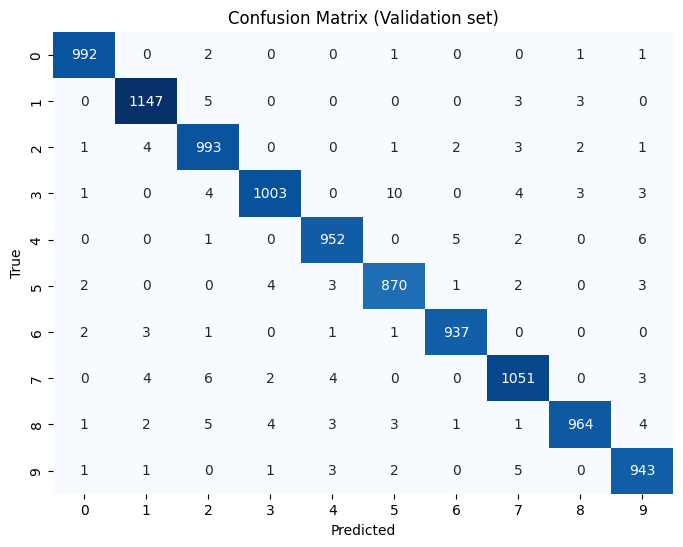

In [19]:
# Evaluate best model
best_svm_model = grid_search_svm.best_estimator_
svm_model, svm_acc = train_and_evaluate(best_svm_model, X_train, y_train, X_val, y_val, set_name="Validation")

In [20]:
# Save trained model 
joblib.dump(svm_model, "svm_model.pkl")

['svm_model.pkl']

## Random Forest

This section implements a Random Forest classifier as another model for MNIST digit classification. Pipeline with GridSearchCV is used to tune hyperparameters like the number of trees (n_estimators), maximum depth, and minimum samples per split. The best model is evaluated on the validation set and saved. 

In [21]:
# Create pipeline for Random Forest
pipeline_rf = Pipeline([
    ("random_forest", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

In [22]:
# Define parameter grid
param_grid_rf = {
    "random_forest__n_estimators": [100, 200, 300],
    "random_forest__max_depth": [None, 20, 30],
    "random_forest__min_samples_split": [2, 5]
}

In [23]:
# Run GridSearchCV
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

# Print results
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best accuracy for Random Forest:", grid_search_rf.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for Random Forest: {'random_forest__max_depth': 30, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 300}
Best accuracy for Random Forest: 0.9665000375739515


Accuracy on Validation set: 0.9713

Classification Report (Validation set):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       997
           1       0.99      0.98      0.99      1158
           2       0.96      0.98      0.97      1007
           3       0.97      0.95      0.96      1028
           4       0.97      0.97      0.97       966
           5       0.96      0.96      0.96       885
           6       0.98      0.99      0.98       945
           7       0.97      0.97      0.97      1070
           8       0.97      0.96      0.96       988
           9       0.95      0.96      0.96       956

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



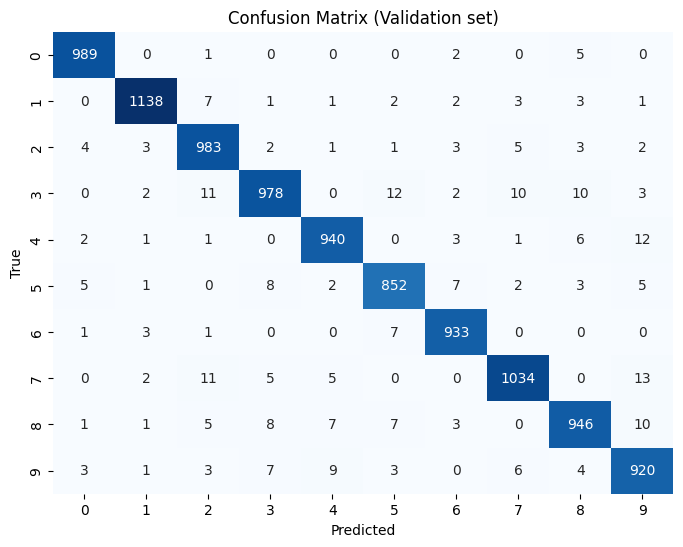

In [24]:
# Evaluate the best model 
best_rf_model = grid_search_rf.best_estimator_
rf_model, rf_acc = train_and_evaluate(best_rf_model, X_train, y_train, X_val, y_val, set_name="Validation")

In [25]:
# Save model
joblib.dump(rf_model, "random_forest_model.pkl")

['random_forest_model.pkl']

## Ensemble

This section creates an ensemble model using a VotingClassifier to combine the Support Vector Machine (SVM) and Random Forest models hoping the strengths of both models (non-linear kernel-based and tree-based approaches) can improve performance on the MNIST classification. The model is evaluated on the validation set and saved for future use.

In [26]:
# Best models
best_svm = grid_search_svm.best_estimator_
best_rf = grid_search_rf.best_estimator_

In [27]:
# Create ensemble
ensemble = VotingClassifier(
    estimators=[
        ("svm", best_svm),
        ("rf", best_rf)
    ],
    voting="hard" 
)

Accuracy on Validation set: 0.9782

Classification Report (Validation set):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       997
           1       0.98      0.99      0.99      1158
           2       0.96      0.98      0.97      1007
           3       0.97      0.97      0.97      1028
           4       0.97      0.99      0.98       966
           5       0.97      0.98      0.97       885
           6       0.99      0.98      0.99       945
           7       0.98      0.97      0.98      1070
           8       0.99      0.96      0.97       988
           9       0.98      0.96      0.97       956

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



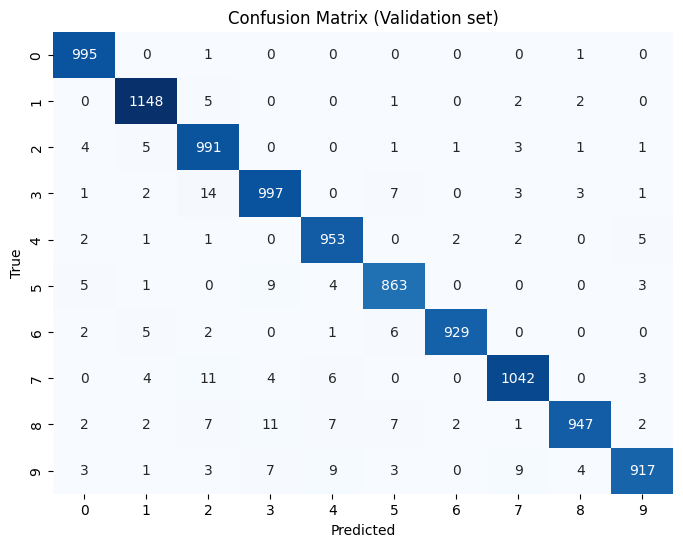

Ensemble accuracy: 0.9782


In [28]:
# Train and evaluate
ensemble_model, ensemble_acc = train_and_evaluate(ensemble, X_train, y_train, X_val, y_val, set_name="Validation")

print(f"Ensemble accuracy: {ensemble_acc:.4f}")

In [29]:
# Save model
joblib.dump(ensemble_model, "ensemble_model.pkl")

['ensemble_model.pkl']

## Comparing Model Results

This section compares the accuracies of the Logistic Regression, Random Forest, SVM, and Ensemble models to evaluate their performance and guides the final model selection. 

In [30]:
# Results
results = {
    "Logistic Regression": lr_acc,
    "Random Forest": rf_acc,
    "SVM": svm_acc,
    "Ensemble": ensemble_acc
}
print("Model comparison:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")

Model comparison:
Logistic Regression: 0.9233
Random Forest: 0.9713
SVM: 0.9852
Ensemble: 0.9782


# Augmentation and Retraining of SVM

This section applies augmentation to the training and validation set to improve the SVM model's robustness. This is especially important for real-world applications like camera feed digit recognition. Augmentation includes rotations, translations, and elastic deformations. The retrained model is evaluated on the test set and the augmented model is saved for deployment.

In [31]:
# Reshape X_train_val for augmentation
X_train_val_reshaped = X_train_val.reshape(-1, 28, 28)

# Define augmentation sequence
seq = iaa.Sequential([
    iaa.Affine(rotate=(-10, 10)),  # Rotate ±10 degrees
    iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}),  # Shifting
    iaa.ElasticTransformation(alpha=0.5, sigma=0.25),  # Elastic deformation
])

# Apply augmentation (3 extra versions per image + original)
augmented_images = []
augmented_labels = []
for img, label in zip(X_train_val_reshaped, y_train_val):
    aug_images = [img] + seq.augment_images([img] * 3)  
    augmented_images.extend(aug_images)
    augmented_labels.extend([label] * 4)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Flatten augmented data for SVC
X_train_val_augmented = augmented_images.reshape(-1, 784)

Retraining SVM model on augmented train_val set...
Accuracy on test set with augmented model: 0.9878


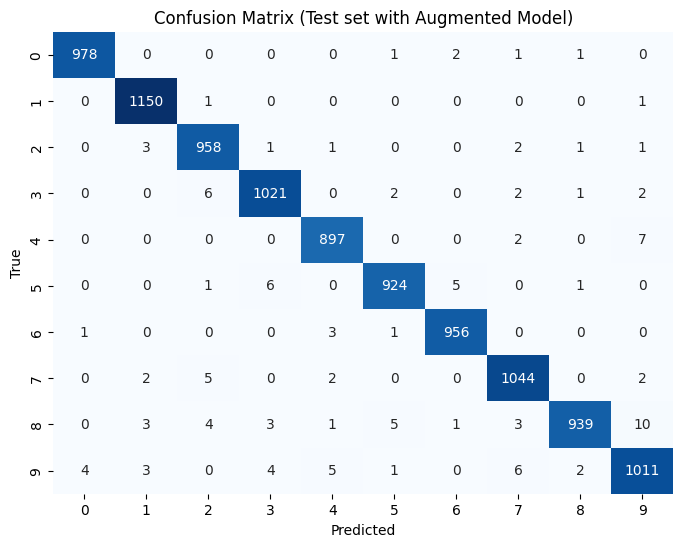

Augmented model saved as svm_augmented_model.pkl


In [32]:
# Retrain SVM with augmented data
print("Retraining SVM model on augmented train_val set...")
svm_model_augmented = SVC(kernel="rbf", C=10.0, gamma="scale", random_state=42)  
svm_model_augmented.fit(X_train_val_augmented, augmented_labels)

# Evaluate on test set
X_test_flat = X_test.reshape(-1, 784)
y_pred_test = svm_model_augmented.predict(X_test_flat)
test_acc_augmented = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on test set with augmented model: {test_acc_augmented:.4f}")

# Plot confusion matrix for test set
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Test set with Augmented Model)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Save the retrained augmented model
joblib.dump(svm_model_augmented, "svm_augmented_model.pkl")
print("Augmented model saved as svm_augmented_model.pkl")

# Conclusion
## Summary of Findings
This project developed a handwritten digit classifier using the MNIST dataset, with the goal of deploying it for real-world camera feed recognition. 
The explored models and techniques were:

- **Baseline Model:** Logistic Regression achieved a validation accuracy of 0.9233, serving as a benchmark.
- **Advanced Models:** Random Forest and SVM outperformed the baseline, with validation accuracies of 0.9713 and 0.9852, respectively. SVM with an RBF kernel was the best individual model, demonstrating a strength in capturing non-linear patterns in image data.
- **Ensemble:** Combining SVM and Random Forest with a VotingClassifier gave an accuracy of 0.9782, slightly below SVM's performance and had limited benefits from ensembling in this case.
- **Augmentation and Retraining:** To improve robustness for real-world applications, augmentation were applied (rotations, translations, elastic deformations) to the training+validation set, increasing the dataset size by x4. Retraining the SVM on this augmented data resulted in a test accuracy of 0.9878, a strong result that aligns with top SVM benchmarks on MNIST that I've found (~0.986–0.99) and this while requiring minimal tuning effort.

## Key Takeaways
- SVM with an RBF kernel was the most effective model, achieving 0.9852 on the validation set and 0.9878 on the test set after augmentation.
- Augmentation is critical for improving generalization, simulating real-world variations like camera angles and handwriting distortions, and preparing the model for deployment in apps like Streamlit.
- The use of moderate hyperparameter ranges, balanced augmentation and still achieve a competitive result, demonstrates the efficiency of SVM for this task.

## Next Steps
- **Deployment:** Deployment of the augmented SVM model (`svm_augmented_model.pkl`) to Streamlit for real-time digit recognition from drawing canvas, image upload and camera feed.
- **Further Improvements could be:** Explore additional augmentations (noise injection, scaling) to potentially boost performance.
